# Introduction

The main goal of this notebook is as follows:

- numpy to VTK using [this](https://pyscience.wordpress.com/2014/09/06/numpy-to-vtk-converting-your-numpy-arrays-to-vtk-arrays-and-files/)
- VTK to volumetric data then mesh data using [this](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/)
- saving to stl [this](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/)

# Imports

In [1]:
import numpy as np
import scipy.io 
import pandas as  pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

# DB

In [3]:
workingDir = 'C:/Cerebral/_MarioSandBox/DB/medicalHolography/vascular/Example/'
dataName = 'VTD_ready_for_ROI_choice.mat'
maskName = 'mask.mat'

In [4]:
def readData(fileLocationAndName,VariableName):
    data = scipy.io.loadmat(fileLocationAndName)
    data = data[VariableName]
    dataArray = np.array(data)
    return dataArray

In [5]:
data = readData(workingDir+dataName,'VTD_ready')
data.shape

(360L, 766L, 760L)

In [6]:
mask = readData(workingDir+maskName,'mask')
mask.shape

(760L, 766L)

# Data Manipulation

In [7]:
def invertImages(stack):
    [slices,w,l] = np.shape(stack)
    invertedImages = np.zeros([slices,l,w])
    numSlices = np.shape(stack)[0]
    for sliceIndex in xrange(numSlices):        
        currentImage = np.fliplr(np.flipud(stack[sliceIndex].T))
        invertedImages[sliceIndex]= currentImage        
    return invertedImages    

# Visualization Functions

In [8]:
def drawSingleImage(stack):
    plt.figure()
    plt.imshow(stack)

In [9]:
def drawSlice(stack,sliceIndex):
    plt.figure()
    plt.imshow(stack[sliceIndex])

In [10]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='jet')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

# Mask Functions

In [11]:
def maskImageStack(stack,mask):    
    maskedImages = np.zeros(np.shape(stack))
    numSlices = np.shape(stack)[0]
    for sliceIndex in xrange(numSlices):
        currentImage = stack[sliceIndex]
        maskedImages[sliceIndex]= np.multiply(currentImage,mask)
    
    return maskedImages    

# Data visualization Functions
- [3D Plotting](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)

In [45]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

import  plotly.plotly  as py
import plotly.graph_objs as go
py.sign_in('mgdev','GRHVEKwb9xgAq7DZSeex')

In [13]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans

In [14]:
def make_mesh(image, threshold=-300, step_size=1):
    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    verts, faces = measure.marching_cubes(p, threshold) 
    #verts, faces, normals, values = measure.marching_cubes_lewiner(p, 0.0)
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print "Drawing"
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print "Drawing"
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    print 'generating poly3d'
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    print 'finished generating poly3d'
    face_color = [1, 1, 0.9]
    print 'adding some colour'
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    print 'setting limits'
    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    print 'adding some colour'
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    print 'showing'
    plt.show()
    print 'finished'

In [15]:
def myplotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print "Drawing"
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap="Portland",
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)


# Main Work

Before doing some mesh generation we need to massage the data such that it looks like the ones we see in the example folder that was given to us.

In [16]:
newData = invertImages(data)

Now let us apply the mask to this new data and then view it again.

In [17]:
maskedData = maskImageStack(newData,mask)

In [18]:
def getTHImageStack(stack):
    [s,l,w] = np.shape(stack)

    for sliceIndex in xrange(s):
        imgSlice = np.zeros([l,w])
        imgSlice = stack[sliceIndex,:,:]
        imgSlice[imgSlice>0]=255
        stack[sliceIndex,:,:] = imgSlice   
    return stack

In [19]:
thImageStack = getTHImageStack(maskedData)

# VTK Integration

In [22]:
import vtk
from vtk.util import numpy_support

In [24]:
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

In [23]:
VTK_data = numpy_support.numpy_to_vtk(num_array=thImageStack[10:15,:,:].ravel(), deep=True, array_type=vtk.VTK_FLOAT)

C:\Users\HP\Anaconda2\lib\site-packages\vtk\util\numpy_support.py:134: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



In [25]:
dmc = vtk.vtkDiscreteMarchingCubes()

In [26]:

dmc.SetInputConnection(VTK_data)

TypeError: SetInputConnection argument 1: method requires a vtkAlgorithmOutput, a vtkFloatArray was provided.

In [47]:
def vtkImageToNumPy(image, pixelDims):
    pointData = image.GetPointData()
    arrayData = pointData.GetArray(0)
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    ArrayDicom = ArrayDicom.reshape(pixelDims, order='F')
    
    return ArrayDicom

In [56]:
def plotHeatmap(array, name="plot"):
    data = Data([
        Heatmap(
            z=array,
            colorscale='Greys'
        )
    ])
    layout = Layout(
        autosize=False,
        title=name
    )
    fig = Figure(data=data, layout=layout)
    
    return py.iplot(fig, filename=name)

# ----------------
[Trying this](https://stackoverflow.com/questions/37283961/python-numpy-array-to-vtk-stl-file-creator-how-to-set-spacing)

In [141]:
stack=thImageStack[10:15,:,:].astype('uint8')
dataImporter = vtk.vtkImageImport()
data_string = stack.tostring()

In [142]:
stack[1,:,:].dtype

dtype('uint8')

In [143]:
dataImporter.CopyImportVoidPointer(data_string, len(data_string))
dataImporter.SetDataScalarTypeToUnsignedChar()
dataImporter.SetNumberOfScalarComponents(1)

In [144]:
d, w, h = stack.shape
dataImporter.SetDataExtent(0, d-1,0, w-1, 0, h-1)
dataImporter.SetWholeExtent(0, d-1,0, w-1, 0, h-1)

In [145]:
#here is the line that I was missing:
dataImporter.SetDataSpacing( 1,1,1)

In [146]:
threshold = vtk.vtkImageThreshold ()
threshold.SetInputConnection(dataImporter.GetOutputPort())
threshold.ThresholdByLower(254) # 255 is the height of the threshold
threshold.ReplaceInOn()
threshold.SetInValue(0) # set all values below the threshold to 0 in this case the threshold is 255
threshold.ReplaceOutOn()
threshold.SetOutValue(1) # set all values above the threshold to 1 in this case the threshold is 255
threshold.Update()

In [147]:
dmc = vtk.vtkDiscreteMarchingCubes()
dmc.SetInputConnection(dataImporter.GetOutputPort())
dmc.GenerateValues(1, 1, 1)
dmc.Update()

In [148]:
writer = vtk.vtkSTLWriter()
writer.SetInputConnection(dmc.GetOutputPort())
writer.SetFileTypeToBinary()
writer.SetFileName("file.stl")
writer.Write()

1

In [151]:
ArrayDicom = vtkImageToNumPy(threshold.GetOutput(), [d, w, h])
plotHeatmap(ArrayDicom[:, 1, :], name="CT_Original")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mgdev/0 or inside your plot.ly account where it is named 'CT_Original'


In [136]:
np.shape(ArrayDicom)

(5L, 760L, 766L)

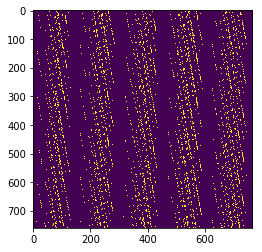

In [137]:
drawSingleImage(ArrayDicom[2])

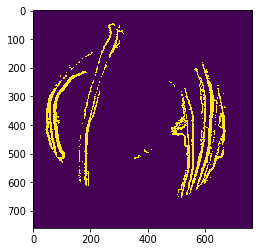

In [138]:
drawSingleImage(stack[2])

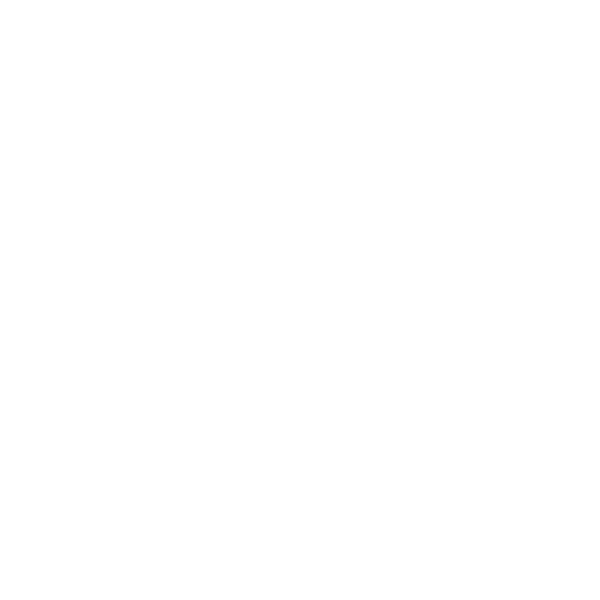

In [102]:
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(dmc.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1.0, 1.0, 1.0)

camera = renderer.MakeCamera()
camera.SetPosition(-500.0, 245.5, 122.0)
camera.SetFocalPoint(301.0, 245.5, 122.0)
camera.SetViewAngle(30.0)
camera.SetRoll(-90.0)
renderer.SetActiveCamera(camera)
vtk_show(renderer, 600, 600)

In [152]:
np.shape(stack)

(5L, 760L, 766L)

In [153]:
np.save('smallStack',stack)

In [154]:
np.save('thStack',thImageStack[0:180,:,:].astype('uint8'))